In [1]:
from quadcoil import quadcoil
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
from jax import block_until_ready
import time
import matplotlib.pyplot as plt
import plotly

In [2]:
from quadcoil.quantity.current import _K
# pass in dofs as dict like {'phi': (the dofs array)}

In [3]:
from simsopt.geo import SurfaceRZFourier
plasma_surface = SurfaceRZFourier.from_wout('wout_li383_1.4m.nc')
net_poloidal_current_amperes = 11884578.094260072

In [4]:
# from simsopt import load
# winding_surface, plasma_surface = load('surfaces.json')
# net_poloidal_current_amperes = 11884578.094260072
# mpol = 4
# ntor = 4
# jax.config.update('jax_enable_x64', False)

In [5]:
# Then, test with REGCOIL, given winding surface.
print('Testing REGCOIL, with known winding surface')
regcoil1_out_dict, regcoil1_qp, regcoil1_dofs, status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=plasma_surface.mpol,
    ntor=plasma_surface.ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    plasma_coil_distance=np.float64(0.32575916842151176),
    # winding_dofs=winding_surface.get_dofs(),
    # winding_mpol=winding_surface.mpol,
    # winding_ntor=winding_surface.ntor,
    # winding_quadpoints_phi=winding_surface.quadpoints_phi,
    # winding_quadpoints_theta=winding_surface.quadpoints_theta,
    objective_name=('f_B', 'f_K'),
    objective_weight=np.array([1., 0.01]),
    objective_unit=(1., 1.),
    metric_name=('f_B', 'f_K'),
    verbose=4
)


Testing REGCOIL, with known winding surface
Plasma-coil distance (m): 0.32575916842151176
Running QUADCOIL in verbose mode 

----- Input summary ----- 
Evaluation phi quadpoint num: 32
Evaluation theta quadpoint num: 34
Plasma phi quadpoint num: 32
Plasma theta quadpoint num: 34
Winding phi quadpoint num: 96
Winding theta quadpoint num: 34
Net poloidal current (A): 11884578.094260072
Net toroidal current (A): 0.0
Constraint names: ()
Constraint types: ()
Constraint units: ()
Constraint values: []
Objective names: ('f_B', 'f_K')
Objective units: (Array(1., dtype=float64), Array(1., dtype=float64))
Objective weights: [1.   0.01]
Numerical parameters:
    c_init: 1.0
    c_growth_rate: 2.0
    xstop_outer: 1e-06
    ctol_outer: 1e-06
    fstop_inner: 1e-06
    xstop_inner: 1e-06
    gtol_inner: 1e-06
    maxiter_tot: 10000
    maxiter_inner: 1000
----- DOF summary ----- 
After converting non-smooth terms (such as |f|) into
smooth terms, auxiliary vars and constraints, the dofs are:
    ph

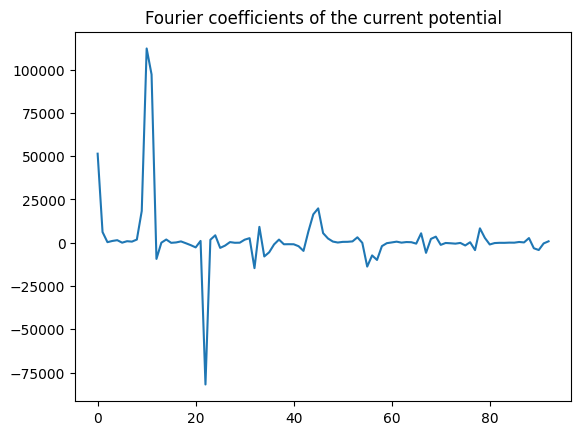

In [6]:
regcoil1_phi_mn = regcoil1_dofs['phi']
plt.title('Fourier coefficients of the current potential')
plt.plot(regcoil1_phi_mn, label='REGCOIL sln (from QUADCOIL surfaces.json)')

In [7]:
import struct
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import netCDF4
thincurr_python_path =  '/home/sseethalla25/OpenFUSIONToolkit/install_release'
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.meshing import build_regcoil_grid, ThinCurr_periodic_toroid
myOFT = OFT_env(nthreads=4)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          f6d11ac
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    4
Fortran input file    = /tmp/oft_67252/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  10
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



In [13]:
# pass in simsopt object for plasma and winding from quadcoil
try:
    from simsopt.geo import SurfaceRZFourier
except ImportError:
    print('Can not import SIMSOPT')
    raise
# Create coil mesh
plasma_grid = plasma_surface.gamma()

winding_surface = regcoil1_qp.eval_surface.to_simsopt()
winding_grid = winding_surface.gamma()
# winding_grid = np.concatenate((winding_grid, winding_grid[:, :1, :]), axis=1)
print(np.shape(winding_grid), np.shape(plasma_grid))

nphi = len(winding_surface.quadpoints_phi)
ntheta = len(winding_surface.quadpoints_theta)
winding_grid = ThinCurr_periodic_toroid(winding_grid,winding_surface.nfp,ntheta,nphi,wrap_n=False, wrap_m=False)
nphi = len(plasma_surface.quadpoints_phi)
ntheta = len(plasma_surface.quadpoints_theta)
plasma_grid = ThinCurr_periodic_toroid(plasma_grid,1,ntheta,nphi)

(32, 34, 3) (61, 62, 3)


In [9]:
nphi, ntheta

(61, 62)

In [13]:
# todo: pass in simsopt object for plasma and winding
def build_quadcoil_json(filename, field_suffix, full_torus=False):
    r'''! Build a uniform grid from a JSON surfaces file

    @param field_suffix Suffix for netCDF fields (eg. "plasma" or "coil")
    @param ntheta Number of points in the \f$ \theta \f$ (poloidal) direction
    @param nphi Number of points (per field period) in the \f$ \phi \f$ (toroidal) direction
    @param full_torus Construct grid for the full torus (default: one field period)
    @result `rgrid` Structed phi-theta grid of points [nphi,ntheta,3], `nfp` Number of field periods
    '''
    try:
        from simsopt import load
    except ImportError:
        print('Can not import SIMSOPT')
        raise
    coil_surface, plasma_surface = load(filename)
    # print(coil_surface.mpol, coil_surface.ntor)

    nfp = 3
    # print(grd.shape)
    # coil_mns, coil_mnc = coil_surface.fourier_transform_scalar(np.ones((nphi, ntheta)), mpol=mpol, ntor=ntor)
    # plasma_mns, plasma_mnc = plasma_surface.fourier_transform_scalar(np.ones((32, ntheta)), mpol=mpol, ntor=ntor)
    if field_suffix == 'plasma':
        nphi = len(plasma_surface.quadpoints_phi)
        ntheta = len(plasma_surface.quadpoints_theta)
        rmnc = plasma_surface.rc
        zmns = plasma_surface.zs
        xm = plasma_surface.m
        xn = plasma_surface.n
        nfp = nfp
        print(nphi, nfp)
        if full_torus:
            nphi *= nfp
            nfp = 1
            print(nphi, nfp)
        ntor = plasma_surface.ntor # simsopt m&n don't include inactive mode pairs, have to recalculate all possible pairs
        mpol = plasma_surface.mpol
        all_m, all_n = np.meshgrid(np.arange(mpol+1), np.arange(-ntor, ntor+1), indexing='ij')
        xm = all_m
        xn = all_n
    if field_suffix == 'coil':
        nphi = len(coil_surface.quadpoints_phi)
        ntheta = len(coil_surface.quadpoints_theta)
        rmnc = coil_surface.rc
        zmns = coil_surface.zs
        xm = coil_surface.m
        xn = coil_surface.n
        nfp = nfp
        if full_torus:
            nphi *= nfp
            nfp = 1
        ntor = coil_surface.ntor # simsopt m&n don't include inactive mode pairs, have to recalculate all possible pairs
        mpol = coil_surface.mpol
        all_m, all_n = np.meshgrid(np.arange(mpol+1), np.arange(-ntor, ntor+1), indexing='ij')
        xm = all_m
        xn = all_n
    # print(xm)
    # print(xn)

    # print(xm)
    # print(xn)
    # print(rmnc)
    # todo: look at simsopt.geo.surface
    theta_span = np.linspace(0.0,2.0*np.pi,ntheta,endpoint=False)
    zeta_span = np.linspace(0.0,2.0*np.pi/nfp,nphi,endpoint=(nfp>1))
    rgrid = np.zeros((zeta_span.shape[0],theta_span.shape[0],3))
    # print(np.shape(rmnc), np.shape(xm), np.shape(xn))
    for j in range(zeta_span.shape[0]):
        for i in range(theta_span.shape[0]):
            r = np.sum(rmnc*np.cos(xm*theta_span[i] - xn*zeta_span[j]))
            z = np.sum(zmns*np.sin(xm*theta_span[i] - xn*zeta_span[j]))
            rgrid[j,i,:] = [r*np.cos(zeta_span[j]), r*np.sin(zeta_span[j]), z]
    return rgrid, nfp

# nphi = len(winding_surface.quadpoints_phi)
# ntheta = len(winding_surface.quadpoints_theta)
# Create coil mesh

coil_grid, nfp = build_quadcoil_json('surfaces.json','coil', full_torus=False)
print(np.shape(coil_grid))
coil_grid = ThinCurr_periodic_toroid(coil_grid,nfp,ntheta,nphi)
# Create plasma mesh
plasma_grid, _ = build_quadcoil_json('surfaces.json','plasma', full_torus=True)
print(np.shape(plasma_grid))
plasma_grid = ThinCurr_periodic_toroid(plasma_grid,1,ntheta,nphi)

(96, 32, 3)
32 3
96 1
(96, 32, 3)


In [ ]:
# Import grid from regcoil file (not ideal)
# nphi = 96
# ntheta = 32
# coil_grid, nfp = build_regcoil_grid('regcoil_out.li383.nc','coil',ntheta,nphi,full_torus=False)
# print(np.shape(coil_grid))
# coil_grid = ThinCurr_periodic_toroid(coil_grid,nfp,ntheta,nphi)
# # Create plasma mesh
# plasma_grid, _ = build_regcoil_grid('regcoil_out.li383.nc','plasma',ntheta,nphi,full_torus=False)
# print(np.shape(plasma_grid))
# plasma_grid = ThinCurr_periodic_toroid(plasma_grid,nfp,ntheta,nphi)

(96, 32, 3)
(96, 32, 3)



Saving mesh: thincurr_plasma.h5

Saving mesh: thincurr_coil.h5


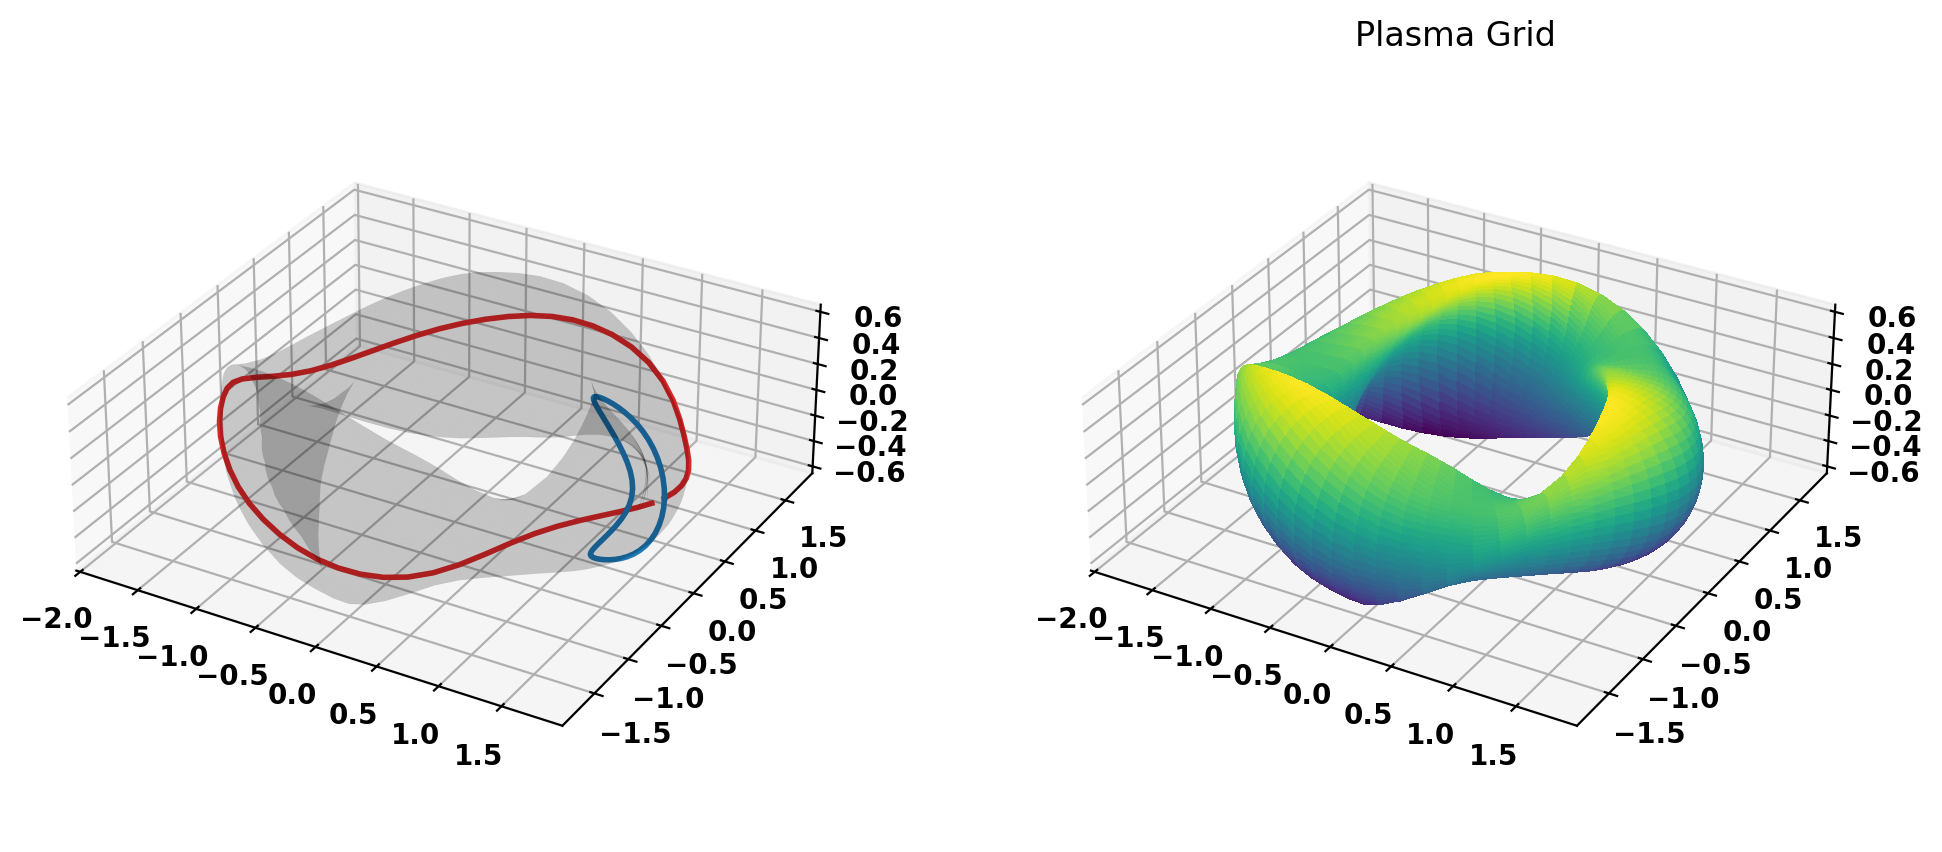

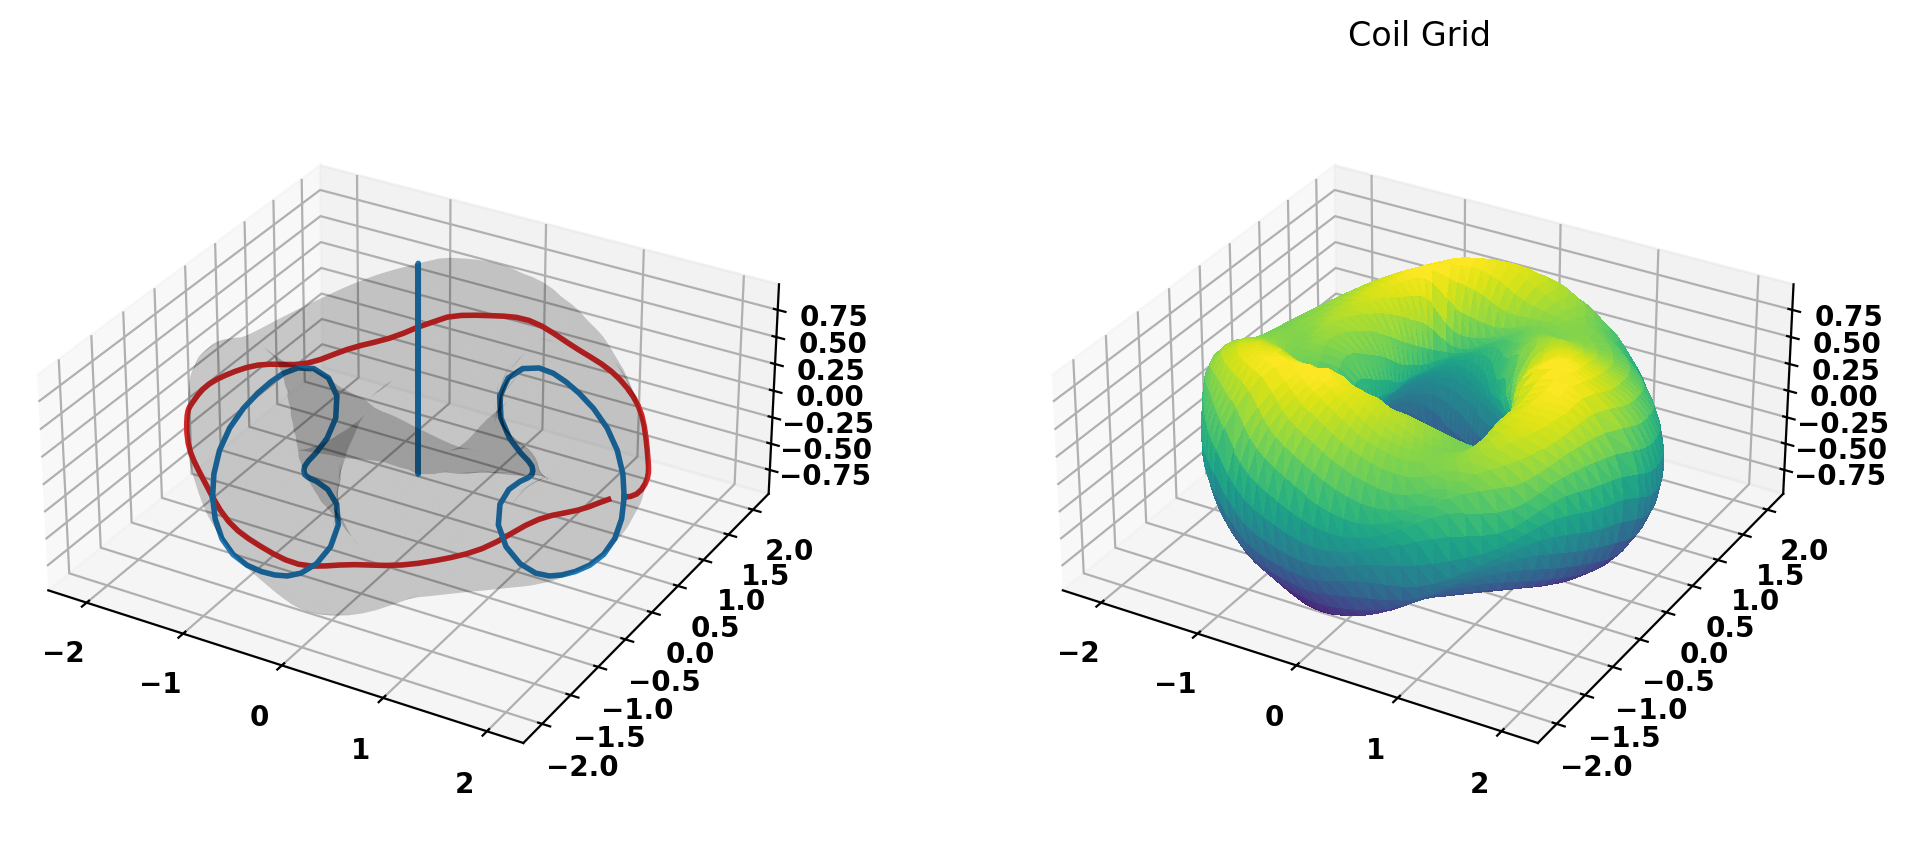

In [11]:
fig = plt.figure(figsize=(12,5))
plasma_grid.plot_mesh(fig)
plt.title('Plasma Grid')
plasma_grid.write_to_file('thincurr_plasma.h5')
fig = plt.figure(figsize=(12,5))
winding_grid.plot_mesh(fig)
plt.title('Coil Grid')
winding_grid.write_to_file('thincurr_coil.h5')

In [11]:
tw_coil = ThinCurr(myOFT)
tw_coil.setup_model(mesh_file='thincurr_coil.h5')
tw_coil.setup_io(basepath='coil')
tw_plasma = ThinCurr(myOFT)
tw_plasma.setup_model(mesh_file='thincurr_plasma.h5')
tw_plasma.setup_io(basepath='plasma')


Creating thin-wall model
 Orientation depth =        6324
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =         3162
  # of edges     =         9486
  # of cells     =         6324
  # of holes     =            4
  # of Vcoils    =            0
  # of closures  =            3
  # of Icoils    =            0

  Building holes

Creating thin-wall model
 Orientation depth =        7564
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =         3782
  # of edges     =        11346
  # of cells     =         7564
  # of holes     =            2
  # of Vcoils    =            0
  # of closures  =            1
  # of Icoils    =            0

  Building holes


In [13]:
coupling = tw_coil.cross_coupling(tw_plasma,cache_file='Lmat_coupling.save')
coupling_new = winding_grid.condense_matrix(coupling,axis=0)
winding_ndofs = coupling_new.shape[1]
del coupling

 Reading element<->element mutual inductance matrix
   Ignoring stored matrix: Model hashes do not match
 Building element<->element mutual inductance matrix
     Time = 36s          


In [14]:
reg_mat = tw_coil.get_regmat()
ncold = int(reg_mat.shape[1]/winding_surface.nfp)
reg_new = winding_grid.condense_matrix(reg_mat[:,:ncold],axis=0)
del reg_mat

In [15]:
# take current matrix and reshape it to [ndofs x nc x 3]
ndofs = len(reg_new)
ncells = len(reg_new[0]) # #of cells/nfp *3
reg_reshape = np.reshape(reg_new, (ndofs, ncells//3, 3)) # ndofs x #cells/nfp x 3
np.shape(reg_reshape)
# average the values in the second index corresponding to the cells that share each edge
# gives you a matrix of size [ndofs, ne, 3]
# winding_grid.plot_mesh(plt.figure())
np.shape(winding_grid.r), np.shape(winding_grid.lc), np.shape(reg_new)
# using winding_grid.lc to make a list of all edges
# iterate through cells 
# if a cell contains an edge add the ndofsx3 matrix to the edge-cell list
# average across the nc dimension
# for each edge it will have ndofs x 3 matrix

((3162, 3), (6072, 3), (1055, 6324))

- Find the mapping from the original grid index space (i,j) to Thincurrs vertex space (one number as a label for the vertex). Likely in build_triangles_from_grid()
    - Then for each edge in the reg_new matrix, convert back to index space
    - if there is an edge [i+/-1, j+/- 1], then that edge is a new edge from the triangle cutting
    - filter the new edges out and you are left with a list of original edges
- now, for each edge find the triangle cells that are touching it (should be two cells per edge)
    - each cell has a ndofs x 3 matrix 
- average the matricies for the cells that have a common edge
- should be left with ndofs x 3 x ne (ne = number of orignal edges)

In [64]:

# assume 32 toroidally, 34 poloidally
# i = toroidal index
# j = poloidal index
tor_resolution = 32
pol_resolution = 34
thin_pol_labels = winding_grid.pnodesets[0] # only take first field period
thin_tor_labels = winding_grid.tnodeset[:tor_resolution] # only take first field period
print(np.shape(thin_pol_labels), np.shape(thin_tor_labels))
thin_labels = []
for tor_label in thin_tor_labels:
    thin_labels.append(tor_label+thin_pol_labels)

thin_labels = np.array(thin_labels)


(34,) (32,)


In [67]:
tor_i = 2
pol_j = 1
temp = thin_labels[tor_i, pol_j]

print(np.shape(thin_labels), temp, np.where(thin_labels == temp))
thin_labels

(32, 34) 69 (array([2]), array([1]))


array([[   0,    1,    2, ...,   31,   32,   33],
       [  34,   35,   36, ...,   65,   66,   67],
       [  68,   69,   70, ...,   99,  100,  101],
       ...,
       [ 986,  987,  988, ..., 1017, 1018, 1019],
       [1020, 1021, 1022, ..., 1051, 1052, 1053],
       [1054, 1055, 1056, ..., 1085, 1086, 1087]])

In [75]:
winding_grid.lc
# for each row (cell) get all 3 edges
# convert back to index space
# check if is a new edge
# if not, add to list
# from the list get all cells that have that edge in winding_grid.lc
# get the ndofs x 3 matrix of the cells from reg_new and average the elements
import numpy as np

def filter_edges_by_index_proximity(lc, thin_labels):
    """
    Extracts edges from a list of triangle vertices (lc) and filters them
    based on the proximity of their [i, j] indices in thin_labels.

    Args:
        lc (np.ndarray): A 2D array where each row is a triangle and contains
                         the 3 original vertex labels.
        thin_labels (np.ndarray): A 2D array of vertex labels used to find
                                  the [i, j] index of a label using np.where.

    Returns:
        list: A list of unique edges (tuples of original vertex labels) that 
              satisfy the inclusion condition.
    """
    valid_edges = []
    
    # Iterate through each triangle (row) in lc
    for triangle_labels in lc:
        # Define the three edges of the triangle
        edges = [
            (triangle_labels[0], triangle_labels[1]),
            (triangle_labels[1], triangle_labels[2]),
            (triangle_labels[2], triangle_labels[0])
        ]
        
        # Process each edge
        for u_label, v_label in edges:
            
            # --- 1. Convert Vertex Labels to [i, j] Indices ---
            
            # Get the indices [i, j] for vertex u
            u_loc = np.where(thin_labels == u_label)
            u_i, u_j = u_loc[0][0], u_loc[1][0]
            
            # Get the indices [i, j] for vertex v
            v_loc = np.where(thin_labels == v_label)
            v_i, v_j = v_loc[0][0], v_loc[1][0]
            
            # --- 2. Apply the Filtering Logic ---
            
            # The rule is: The edge is NOT added if (u_i != v_i) AND (u_j != v_j) 
            # (i.e., both indices are different/it's a diagonal-like jump).
            
            # Therefore, the edge IS ADDED if AT LEAST ONE index is the same:
            # (u_i == v_i) OR (u_j == v_j)
            
            if u_i == v_i or u_j == v_j:
                
                # --- 3. Store the Edge (Normalize and Check for Duplicates) ---
                
                # Normalize the edge representation (e.g., (1, 5) instead of (5, 1))
                normalized_edge = tuple(sorted((u_label, v_label)))
                
                # Only add the edge if it's not already in the list
                if normalized_edge not in valid_edges:
                    valid_edges.append(normalized_edge)
                    
    return valid_edges

# Example Demonstration
# =========================================================================

# 1. Define the Index Grid (thin_labels)
# The position of the label in this grid determines its [i, j] index.
thin_labels1 = np.array([
    [10, 11, 12],  # i=0
    [20, 21, 22],  # i=1
    [30, 31, 32]   # i=2
])

# 2. Define the Triangles (lc)
# Edges:
# (10, 21): 10=[0,0], 21=[1,1]. Both i and j are different. -> EXCLUDED
# (21, 11): 21=[1,1], 11=[0,1]. j is the same (1==1).      -> INCLUDED
# (11, 10): 11=[0,1], 10=[0,0]. i is the same (0==0).      -> INCLUDED
# (20, 22): 20=[1,0], 22=[1,2]. i is the same (1==1).      -> INCLUDED
lc = np.array([
    [10, 21, 11], 
    [20, 21, 31] 
])

result = filter_edges_by_index_proximity(winding_grid.lc, thin_labels)

print("--- Inputs ---")
# print(f"Thin Labels (Index Grid):\n{thin_labels1}")
# print(f"Triangle Labels (lc):\n{lc}")
print("\n--- Result ---")
print(f"Filtered Edges:\n{result}")

IndexError: index 0 is out of bounds for axis 0 with size 0

In [45]:
gamma = winding_surface.gamma() # toroidal, poloidal, xyz
print(np.shape(gamma))
gamma[:,0,0]

(32, 34, 3)


array([ 2.04291438e+00,  2.03960271e+00,  2.02883612e+00,  2.00868635e+00,
        1.97744814e+00,  1.93484531e+00,  1.88237327e+00,  1.82263057e+00,
        1.75812278e+00,  1.69025668e+00,  1.61899618e+00,  1.54318305e+00,
        1.46119040e+00,  1.37154186e+00,  1.27330688e+00,  1.16626969e+00,
        1.05094158e+00,  9.28465678e-01,  8.00434170e-01,  6.68644089e-01,
        5.34832807e-01,  4.00431150e-01,  2.66364804e-01,  1.32955041e-01,
        1.24308099e-16, -1.32912661e-01, -2.65942697e-01, -3.98624548e-01,
       -5.29855631e-01, -6.58320510e-01, -7.83101514e-01, -9.04028805e-01])

In [20]:
np.shape(winding_grid.pnodesets),np.shape(winding_grid.tnodeset)

((3, 34), (93,))

In [24]:
winding_grid.pnodesets

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 array([1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064,
        1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075,
        1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086,
        1087]),
 array([2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118,
        2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129,
        2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140,
        2141])]

In [36]:
print(np.shape(winding_grid.r), np.shape(gamma))
print(winding_grid.r[-1])
print(gamma[-1,-1,:])

(3162, 3) (32, 34, 3)
[ 2.01506283 -0.26528805 -0.10692469]
[-0.89725174  1.81944655 -0.15086044]


In [44]:
len(winding_grid.tnodeset)

93

In [37]:
winding_surface.plot(engine="plotly", close=False)

In [73]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np


def plot_mesh_plotly(grid, equal_aspect=True, surf_alpha=0.1, surf_cmap='Viridis'):
    
    # 1. Setup the figure with two subplots
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{'type': 'scene'}, {'type': 'scene'}]], # Use 'scene' for 3D plots
    )

    # --- Data Extraction (Simulated for Plotly) ---
    r = grid.r
    lc = grid.lc
    tnodeset = grid.tnodeset
    pnodesets = grid.pnodesets
    
    # --- Calculate Aspect Ratio (if needed) ---
    if equal_aspect:
        mesh_range = np.ptp(r, axis=0)
        max_range = np.max(mesh_range)
        # Plotly requires ranges for axis definition
        x_range = [np.min(r[:,0]), np.max(r[:,0])]
        y_range = [np.min(r[:,1]), np.max(r[:,1])]
        z_range = [np.min(r[:,2]), np.max(r[:,2])]
    
    # ====================================================================
    # PLOT 1: Wireframe and Boundaries (Matplotlib subplot 1,2,1)
    # ====================================================================

    # 2. Plot the main boundary (self.tnodeset) - Corresponds to ax.plot in 'tab:red'
    fig.add_trace(
        go.Scatter3d(
            x=r[tnodeset, 0], y=r[tnodeset, 1], z=r[tnodeset, 2],
            mode='lines',
            line=dict(color='red', width=4),
            name='Boundary'
        ),
        row=1, col=1
    )

    # 3. Plot the secondary boundaries (self.pnodesets) - Corresponds to ax.plot in 'tab:blue'
    for i, pnodeset in enumerate(pnodesets):
        pnodeset_tmp = np.append(pnodeset, (pnodeset[0],)) # Close the loop
        fig.add_trace(
            go.Scatter3d(
                x=r[pnodeset_tmp, 0], y=r[pnodeset_tmp, 1], z=r[pnodeset_tmp, 2],
                mode='lines',
                line=dict(color='blue', width=2),
                showlegend=(i == 0), # Only show legend once
                name='P-Node Set'
            ),
            row=1, col=1
        )

    # 4. Plot the surface mesh (black wireframe) - Corresponds to ax.plot_trisurf (black)
    fig.add_trace(
        go.Mesh3d(
            x=r[:, 0], y=r[:, 1], z=r[:, 2],
            i=lc[:, 0], j=lc[:, 1], k=lc[:, 2],
            color='black',
            opacity=surf_alpha,
            name='Surface',
            # Add wireframe outline
            contour=dict(show=True, color='gray', width=1)
        ),
        row=1, col=1
    )

    # ====================================================================
    # PLOT 2: Colored Surface Mesh (Matplotlib subplot 1,2,2)
    # ====================================================================

    # 5. Plot the surface mesh (colored by z-height) - Corresponds to ax.plot_trisurf (cmap)
    fig.add_trace(
        go.Mesh3d(
            x=r[:, 0], y=r[:, 1], z=r[:, 2],
            i=lc[:, 0], j=lc[:, 1], k=lc[:, 2],
            intensity=r[:, 2], # Color by Z-coordinate (or you could use a scalar field)
            colorscale=surf_cmap,
            showscale=False,
            name='Colored Surface'
        ),
        row=1, col=2
    )

    # 6. Apply aspect ratio correction
    if equal_aspect:
        # Plotly sets equal aspect ratio by explicitly setting the scale factor
        fig.update_scenes(
            aspectmode='data', # Use data units for aspect ratio
            # Set the entire range based on the largest dimension for true equal aspect (optional)
            xaxis=dict(range=x_range, autorange=False),
            yaxis=dict(range=y_range, autorange=False),
            zaxis=dict(range=z_range, autorange=False),
            # Set the aspect ratio manually
            aspectratio=dict(x=mesh_range[0]/max_range, y=mesh_range[1]/max_range, z=mesh_range[2]/max_range)
        )
    
    # 7. Final layout adjustments (optional)
    fig.update_layout(
        title_text="Mesh Visualization (Plotly)",
        height=700,
        showlegend=True
    )
    
    return fig

plot_mesh_plotly(winding_grid)

# W/O Simsopt version

In [2]:
data_dict = jnp.load('li383_minimum_example.npy', allow_pickle=True).item()
winding_surface = data_dict['winding_surface']
plasma_surface = data_dict['plasma_surface']
net_poloidal_current_amperes = data_dict['net_poloidal_current_amperes']
plasma_coil_distance = data_dict['plasma_coil_distance']
net_poloidal_current_amperes = 11884578.094260072
mpol = 4
ntor = 4
# jax.config.update('jax_enable_x64', True)


In [14]:
# Then, test with REGCOIL, given winding surface.
print('Testing REGCOIL, with known winding surface')
regcoil2_out_dict, regcoil2_qp, regcoil2_dofs, status = quadcoil(
    nfp=plasma_surface.nfp,
    stellsym=plasma_surface.stellsym,
    mpol=mpol,
    ntor=ntor,
    plasma_dofs=plasma_surface.get_dofs(),
    plasma_mpol=plasma_surface.mpol,
    plasma_ntor=plasma_surface.ntor,
    net_poloidal_current_amperes=net_poloidal_current_amperes,
    net_toroidal_current_amperes=0.,
    winding_dofs=winding_surface.get_dofs(),
    winding_mpol=winding_surface.mpol,
    winding_ntor=winding_surface.ntor,
    winding_quadpoints_phi=winding_surface.quadpoints_phi,
    winding_quadpoints_theta=winding_surface.quadpoints_theta,
    objective_name=('f_B', 'f_K'),
    objective_weight=np.array([1., 0.01]),
    objective_unit=(1., 1.),
    metric_name=('f_B', 'f_K'),
    verbose=2
)

Testing REGCOIL, with known winding surface


NameError: name 'winding_surface' is not defined

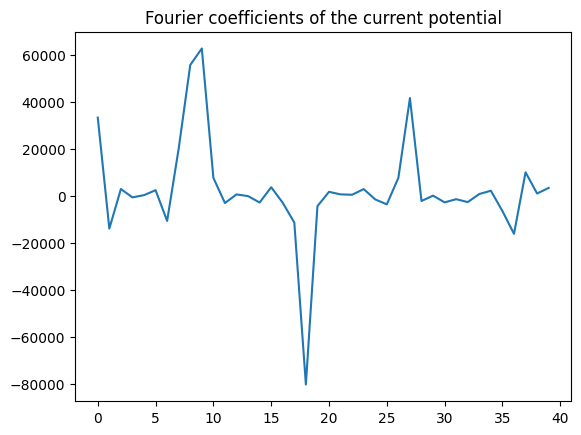

In [4]:
regcoil2_phi_mn = regcoil2_dofs['phi']
plt.title('Fourier coefficients of the current potential')
plt.plot(regcoil2_phi_mn, label='REGCOIL sln (from QUADCOIL)')